In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve as lk
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile

In [2]:
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  after removing the cwd from sys.path.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  if __name__ == '__main__':
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  if __name__ == '__main__':
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: Li

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

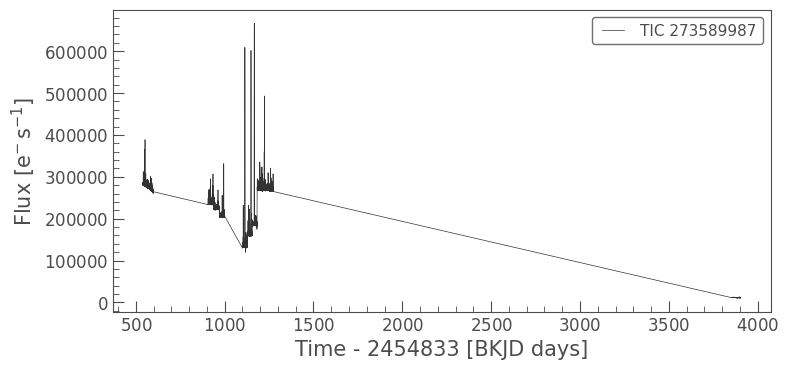

In [3]:
gj1243lc.plot()

Importing in a few flare stars from short cadence TESS data

In [4]:
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy.timeseries import TimeSeries
from astropy.utils.data import get_pkg_data_filename

In [5]:
fs1 = get_pkg_data_filename('/Users/lupitatovar/local_flares/TESS_Flare_Stars/tess2020294194027-s0031-0000000197829751-0198-a_fast-lc.fits')
fs2 = get_pkg_data_filename('/Users/lupitatovar/local_flares/TESS_Flare_Stars/tess2020_match_2min_294194027-s0031-0000000197829751-0198-s_lc.fits')
fs3 = get_pkg_data_filename('/Users/lupitatovar/local_flares/TESS_Flare_Stars/tess2020351194500-s0033-0000000272232401-0203-a_fast-lc.fits')

In [6]:
#fs1
fs2

'/Users/lupitatovar/local_flares/TESS_Flare_Stars/tess2020_match_2min_294194027-s0031-0000000197829751-0198-s_lc.fits'

In [7]:
lc1 = TimeSeries.read(fs1,format='tess.fits')
lc2 = TimeSeries.read(fs2,format='tess.fits')
lc3 = TimeSeries.read(fs3,format='tess.fits')

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 6045 rows with NaN times
  warnings.warn('Ignoring {} rows with NaN times'.format(np.sum(nans)))
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1009 rows with NaN times
  warnings.warn('Ignoring {} rows with NaN times'.format(np.sum(nans)))
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 6750 rows with NaN times
  warnings.warn('Ignoring {} rows with NaN times'.format(np.sum(nans)))


In [8]:
#lc1['time', 'sap_flux']
lc1.time.mjd

array([59144.00942617, 59144.00965765, 59144.00988913, ...,
       59169.44652103, 59169.44675251, 59169.44698399])

Text(0, 0.5, 'SAP Flux (e-/s)')

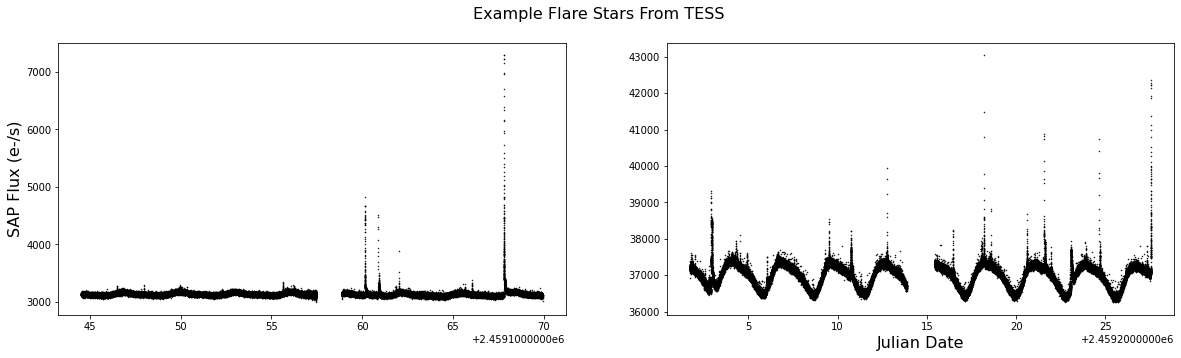

In [9]:
fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.suptitle('Example Flare Stars From TESS',fontsize='16')

axs[0].plot(lc1.time.jd, lc1['sap_flux'], 'k.', markersize=1)
#axs[1].plot(lc2.time.jd, lc2['sap_flux'], 'k.', markersize=1)
axs[1].plot(lc3.time.jd, lc3['sap_flux'], 'k.', markersize=1)


axs[1].set_xlabel('Julian Date',fontsize='16')
axs[0].set_ylabel('SAP Flux (e-/s)',fontsize='16')

Text(0, 0.5, 'SAP Flux (e-/s)')

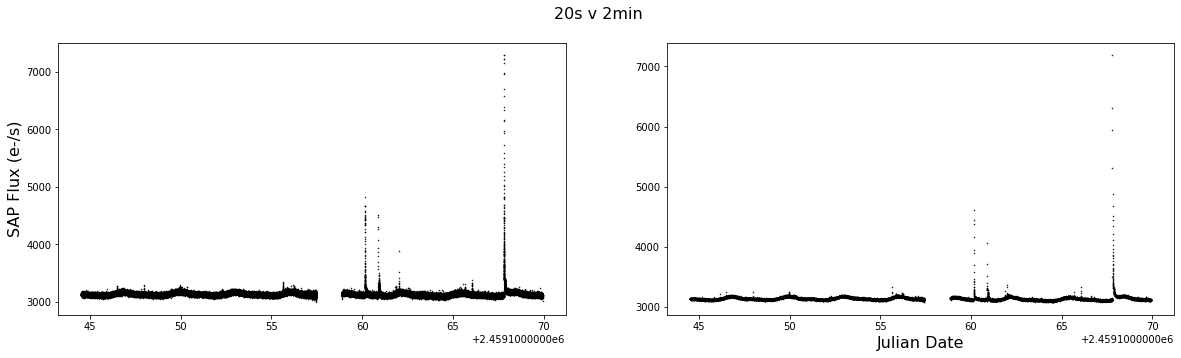

In [10]:
fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.suptitle('20s v 2min',fontsize='16')

axs[0].plot(lc1.time.jd, lc1['sap_flux'], 'k.', markersize=1)
axs[1].plot(lc2.time.jd, lc2['sap_flux'], 'k.', markersize=1)


axs[1].set_xlabel('Julian Date',fontsize='16')
axs[0].set_ylabel('SAP Flux (e-/s)',fontsize='16')

In [11]:
from scipy import special
def flare_model(t,tpeak, fwhm, ampl):

    t_new = (t-tpeak)/fwhm +2


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = [2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
    return flare * ampl

In [12]:
from scipy.stats import binned_statistic

def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

In [16]:
#FINAL KEPLER MODEL
def flare_model_v2(t,tpeak, fwhm, ampl, upsample=True, uptime=10):

    t_new = (t-tpeak)/fwhm +2


    #Values were fit & calculated using MCMC 256 walkers and 30000 steps

    A,B,C,D1,D2,f1 = A,B,C,D1,D2,f1 = [3.6281105426668883,1.7500017640073082,0.2035997267409103,1.3548846737678661,0.179091454739574,0.8107078443451485]
    #[3.46452433, 1.74147744, 0.21642749, 0.22529023, 1.39565111, 0.21624606]

    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    
    if upsample:
        dt = np.nanmedian(np.diff(np.abs(t_new)))
        timeup = np.linspace(min(t_new)-dt, max(t_new)+dt, t_new.size * uptime)

        flareup = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-timeup)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (timeup/C))))
                                                 + (f2 * np.exp((D2*(B-timeup)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (timeup/C)))))

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t_new-dt/2.,[max(t_new)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',bins=downbins)
    else:
        flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
        
    erf_bound = 0.5*(special.erf((t_new)*100) + 1)
    
    return flare * ampl * erf_bound 

In [17]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
#rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

(2459160.87, 2459160.95)

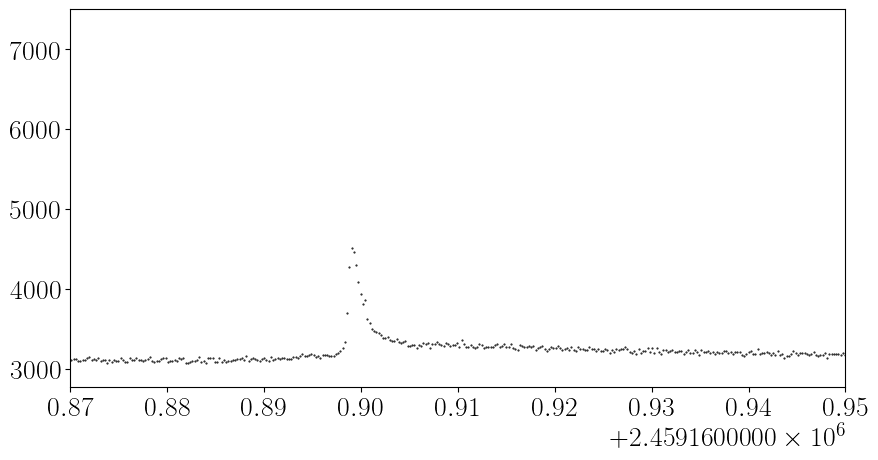

In [18]:
plt.figure(figsize=(10,5))
plt.plot(lc1.time.jd, lc1['sap_flux'], 'k.', markersize=1)
#plt.xlim(2.65e6,2.70e6)
plt.xlim(60.87+2.4591e6,60.95+2.4591e6)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Flux')

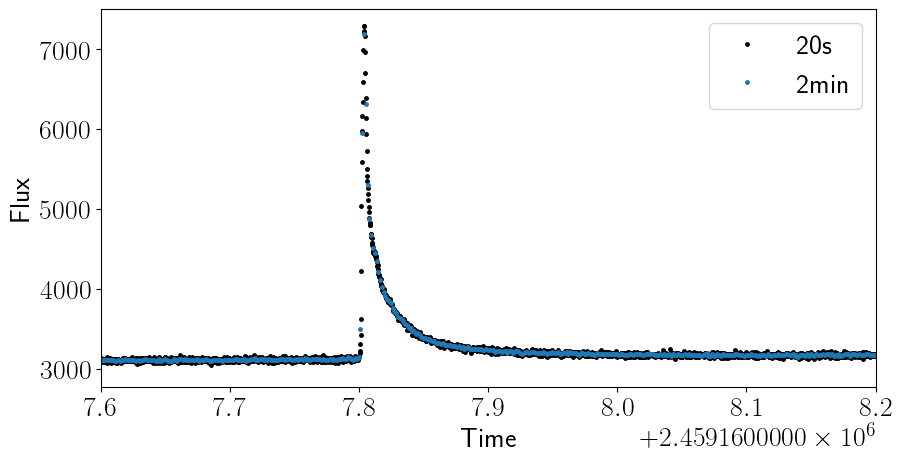

In [19]:
plt.figure(figsize=(10,5))
plt.plot(lc1.time.jd, lc1['sap_flux'], 'k.', markersize=5,label='20s')
plt.plot(lc2.time.jd, lc2['sap_flux'], 'k.', markersize=5,color='C0',label='2min')
plt.xlim(67.6+2.4591e6,68.2+2.4591e6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Flux')

In [20]:
lc1median = (lc1['sap_flux']/np.nanmedian(lc1['sap_flux']))-1
lc2median = (lc2['sap_flux']/np.nanmedian(lc2['sap_flux']))-1

Text(0, 0.5, 'Relative Flux')

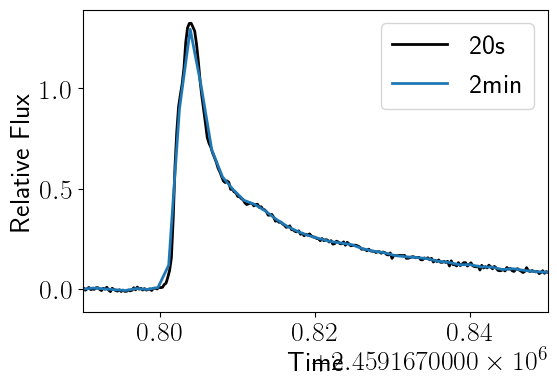

In [21]:
plt.plot(lc1.time.jd,lc1median,color='black', label='20s',lw=2)
plt.plot(lc2.time.jd,lc2median,color='C0',label='2min',lw=2)
plt.xlim(67.79+2.4591e6,67.85+2.4591e6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Relative Flux')

In [22]:
mask = ~(np.isnan(lc1.time.jd) | np.isnan(lc1median))
print(mask)

[False False False ...  True  True  True]


In [23]:
xmin = 67.6+2.4591e6
xmax = 68.2+2.4591e6
x_mask = np.where((lc1.time.jd[mask] > xmin) & (lc1.time.jd[mask] < xmax))[0]
print(len(x_mask))
print(len(lc1.time.jd))

2592
103848


In [24]:
print(len(lc1.time.jd[mask][x_mask]))
print(len(lc1median[mask][x_mask]))

2592
2592


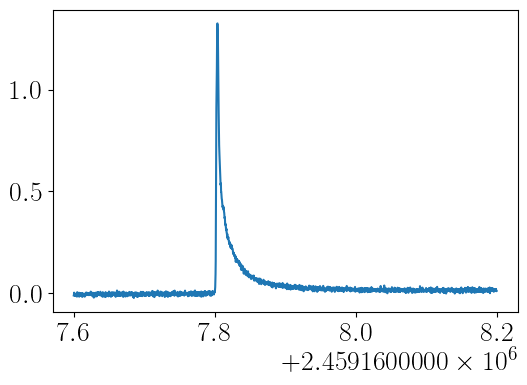

In [25]:
plt.plot(lc1.time.jd[mask][x_mask],lc1median[mask][x_mask])

In [26]:
#np.polyfit(lc1.time.jd[mask][x_mask],lc1median[mask][x_mask], 2)

Fitting new analytical model

In [27]:
from scipy.optimize import curve_fit
xfit = lc1.time.jd[mask][x_mask] - 2.45916781e+06 # approx t_peak
yfit = lc1median[mask][x_mask]

In [28]:
print(len(xfit))
print(len(yfit))

2592
2592


In [29]:
#init_vals= [2.45916777e+06, 1.72434046e-02, 6.99969939e-01]
#init_vals =[2.45916714e+06, 0.4,1.4]
#bounds=((xmin,2e-02,6e-01),(xmax,1,1.5))

#init_vals= [2.45916779e+06, .65e-02, 1.389] #These look a lot better!
#init_vals =[-0.005, .7e-02, 1.38] #Jim's vals
init_vals=[-0.00628625,  0.005,  1.4]
popt, pcov = curve_fit(flare_model, xfit,yfit, p0=init_vals,maxfev=100000)

(-0.05, 0.1)

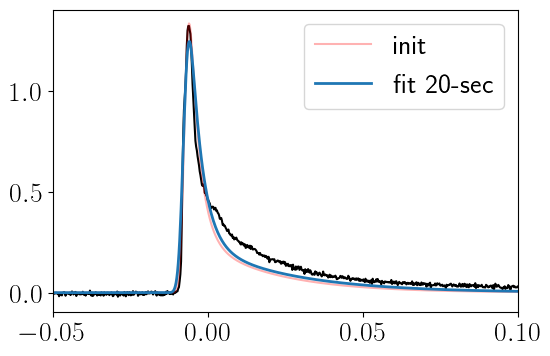

In [30]:
plt.plot(xfit,yfit,color='black')
plt.plot(xfit, flare_model(xfit, *init_vals),color='red', label='init', alpha=0.3)
plt.plot(xfit, flare_model(xfit, *popt),color='C0', label='fit 20-sec', lw=2)
plt.legend()
plt.xlim(-0.05,0.1)

In [31]:
print(popt)
print(pcov)

[-0.00628627  0.00605056  1.30644579]
[[ 3.27744841e-10  2.58007176e-10 -2.78555420e-08]
 [ 2.58007176e-10  3.14097031e-09 -3.39112420e-07]
 [-2.78555420e-08 -3.39112420e-07  7.10876434e-05]]


Fitting Jim's 2014 Model

In [32]:
#bounds=((xmin,2e-02,6e-01),(xmax,1,1.5))

#init_vals2= [2.45916793e+06, 3.01631592e-02, 6.01085052e-01]
#init_vals2 =[2.45916780e+06, .7e-02, 1.35]

init_vals2 =[-0.005, .7e-02, 1.39] #Jim's vals
j_popt, j_pcov = curve_fit(aflare1, xfit,yfit, p0=init_vals2,maxfev=100000)#,bounds=bounds)
print(j_popt)
print(j_pcov)

[-0.00616781  0.00601594  1.3806921 ]
[[ 2.42664578e-10  2.11320334e-10 -2.24168832e-08]
 [ 2.11320334e-10  3.12906826e-09 -3.57689234e-07]
 [-2.24168832e-08 -3.57689234e-07  7.35034884e-05]]


fitting v2 flare model

In [33]:
init_vals_v2=[-0.00628625,  0.005,  1.4]
popt_v2, pcov_v2 = curve_fit(flare_model_v2, xfit,yfit, p0=init_vals_v2,maxfev=100000)
print(popt_v2)
print(pcov_v2)

[-0.00626356  0.00604014  1.31427302]
[[ 1.42330258e-10  2.58961094e-10 -2.82010103e-08]
 [ 2.58961094e-10  1.64630774e-09 -1.79275170e-07]
 [-2.82010103e-08 -1.79275170e-07  3.41367434e-05]]


Text(0.5, 1.0, '20 Second TESS Data')

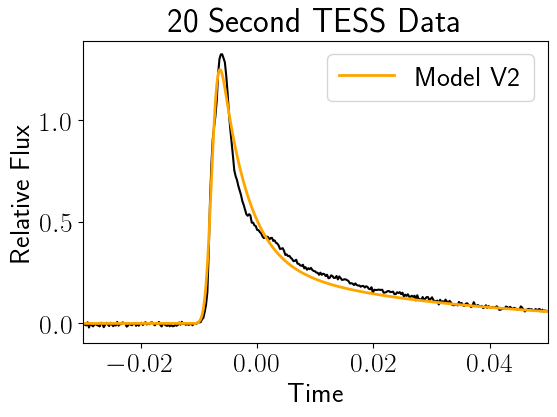

In [34]:
plt.plot(xfit,yfit,color='black')
#plt.plot(xfit, aflare1(xfit, *init_vals2),color='red', label='init', alpha=0.3)
#plt.plot(xfit, aflare1(xfit, *j_popt),color='C0', label='Jim Model', lw=2)
#plt.plot(xfit, flare_model(xfit, *popt),color='purple', label='Model V1', lw=2)
plt.plot(xfit, flare_model_v2(xfit,*popt_v2),color='orange',label='Model V2',lw=2)
plt.legend()
plt.xlim(-0.03,0.05)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.title('20 Second TESS Data')

Note: Given the structure of this flare in the 20s data this may be a complex flare and would explain why our models aren't fitting the data as well as they normally would

### If the 20s data were sampled at 2min what would the fit look like?


In [35]:
xmin = 67.6+2.4591e6
xmax = 68.2+2.4591e6
mask2 = ~(np.isnan(lc2.time.jd) | np.isnan(lc2median))
x_mask2 = np.where((lc2.time.jd[mask2] > xmin) & (lc2.time.jd[mask2] < xmax))[0]
print(len(x_mask2))
print(len(lc2.time.jd))

432
17305


In [36]:
xfit_2min = lc2.time.jd[mask2][x_mask2] - 2.45916781e+06 # approx t_peak
yfit_2min = lc2median[mask2][x_mask2]

In [37]:
p0 =[-0.005, .7e-02, 1.38] #Jim's vals
#init_vals=[2.45916779e+06, 7.00000000e-03, 1.39000000e+00]
popt2, pcov2 = curve_fit(flare_model, xfit_2min,yfit_2min, p0=p0,maxfev=100000)
print(popt2)
print(pcov2)

[-0.00625875  0.00625167  1.2834255 ]
[[ 1.92990476e-09  1.51994553e-09 -1.56007232e-07]
 [ 1.51994553e-09  1.85190592e-08 -1.90089863e-06]
 [-1.56007232e-07 -1.90089863e-06  3.78634534e-04]]


Text(0.5, 1.0, '2min TESS Data')

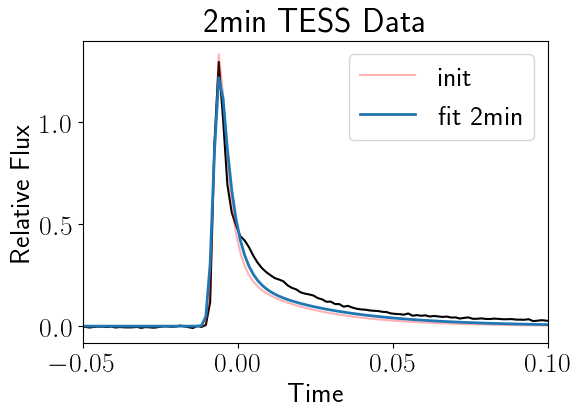

In [38]:
plt.plot(xfit_2min,yfit_2min,color='black')
plt.plot(xfit_2min, flare_model(xfit_2min, *init_vals),color='red', label='init', alpha=0.3)
plt.plot(xfit_2min, flare_model(xfit_2min, *popt2),color='C0', label='fit 2min', lw=2)
plt.legend()
plt.xlim(-0.05,0.1)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.title('2min TESS Data')

Fitting 2min data w/Jim's model

In [39]:
init_vals2min =[-0.005, .7e-02, 1.38] #Jim's vals
j2_popt, j2_pcov = curve_fit(aflare1, xfit_2min,yfit_2min, p0=init_vals2min,maxfev=100000)#,bounds=bounds)
print(j2_popt)
print(j2_pcov)

[-0.00609218  0.0064999   1.30736947]
[[ 1.42195171e-09 -1.34372129e-10  1.36413238e-07]
 [-1.34372129e-10  1.75803564e-08 -1.68369230e-06]
 [ 1.36413238e-07 -1.68369230e-06  3.30788103e-04]]


Fitting V2 of the model

In [40]:
init_2min_v2 =[-0.005, .7e-02, 1.38] #Jim's vals
v2_popt, v2_pcov = curve_fit(flare_model_v2, xfit_2min,yfit_2min, p0=init_2min_v2,maxfev=100000)#,bounds=bounds)
print(v2_popt)
print(v2_pcov)

[-0.00624806  0.00597299  1.3284828 ]
[[ 7.50736997e-10  1.33477582e-09 -1.51976427e-07]
 [ 1.33477582e-09  9.38756647e-09 -1.07310441e-06]
 [-1.51976427e-07 -1.07310441e-06  1.98278224e-04]]


Text(0.5, 1.0, '2 min TESS Data')

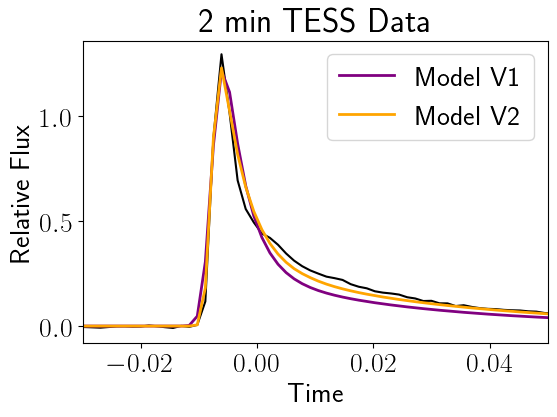

In [41]:
plt.plot(xfit_2min,yfit_2min,color='black')
#plt.plot(xfit_2min, flare_model(xfit_2min, *init_vals),color='red', label='init', alpha=0.3)


#plt.plot(xfit_2min, aflare1(xfit_2min, *j2_popt),color='C0', label='Jim Model', lw=2)
plt.plot(xfit_2min, flare_model(xfit_2min, *popt2),color='purple', label='Model V1', lw=2)
plt.plot(xfit_2min, flare_model_v2(xfit_2min, *v2_popt),color='orange', label='Model V2', lw=2)
plt.legend()
plt.xlim(-0.03,0.05)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.title('2 min TESS Data')

Text(0.5, 1.0, '2 min TESS Data')

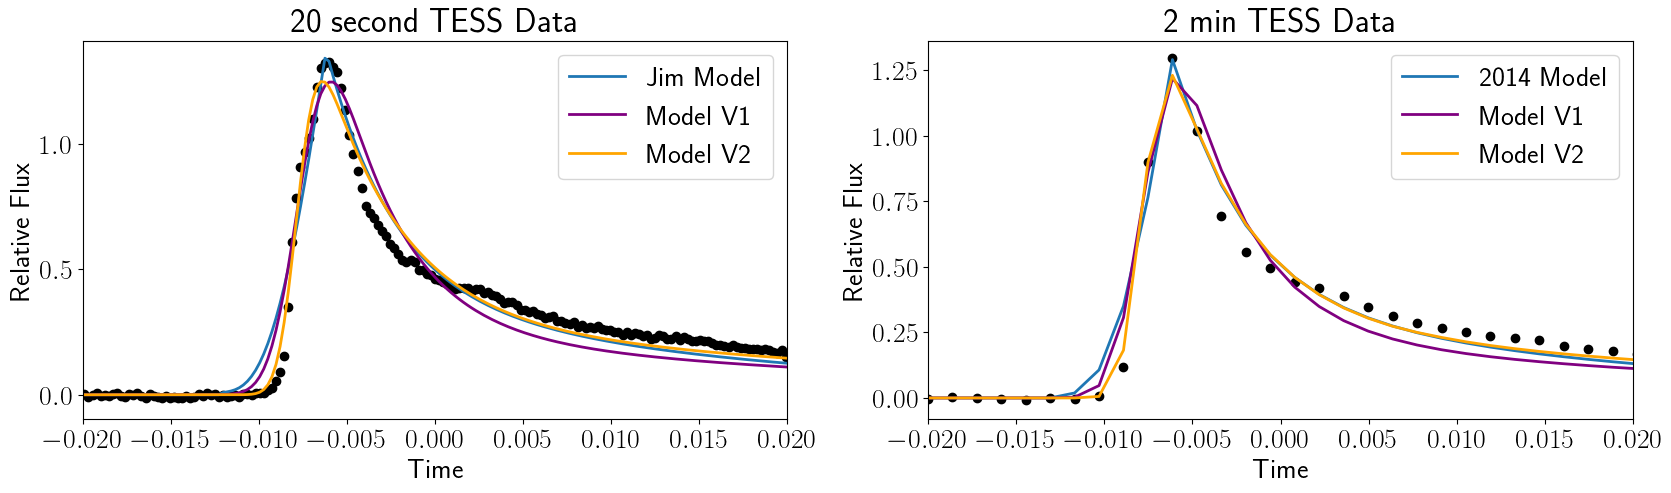

In [42]:
fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k')
axs[0].scatter(xfit,yfit,color='black')
#plt.plot(xfit, aflare1(xfit, *init_vals2),color='red', label='init', alpha=0.3)
axs[0].plot(xfit, aflare1(xfit, *j_popt),color='C0', label='Jim Model', lw=2)
axs[0].plot(xfit, flare_model(xfit, *popt),color='purple', label='Model V1', lw=2)
axs[0].plot(xfit, flare_model_v2(xfit,*popt_v2),color='orange',label='Model V2',lw=2)
axs[0].legend()
axs[0].set_xlim(-0.02,0.02)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Relative Flux')
axs[0].set_title('20 second TESS Data')


axs[1].scatter(xfit_2min,yfit_2min,color='black')
#plt.plot(xfit_2min, flare_model(xfit_2min, *init_vals),color='red', label='init', alpha=0.3)
axs[1].plot(xfit_2min, aflare1(xfit_2min, *j2_popt),color='C0', label='2014 Model', lw=2)
axs[1].plot(xfit_2min, flare_model(xfit_2min, *popt2),color='purple', label='Model V1', lw=2)
axs[1].plot(xfit_2min, flare_model_v2(xfit_2min, *v2_popt),color='orange', label='Model V2', lw=2)
axs[1].legend()
axs[1].set_xlim(-0.02,0.02)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Relative Flux')
axs[1].set_title('2 min TESS Data')
#plt.savefig('/Users/lupitatovar/local_flares/figures/tess_exs_cmplx_fit.pdf')

### Since the flare above is likely to be a complex event we choose another flare to model

(2459160.87, 2459160.95)

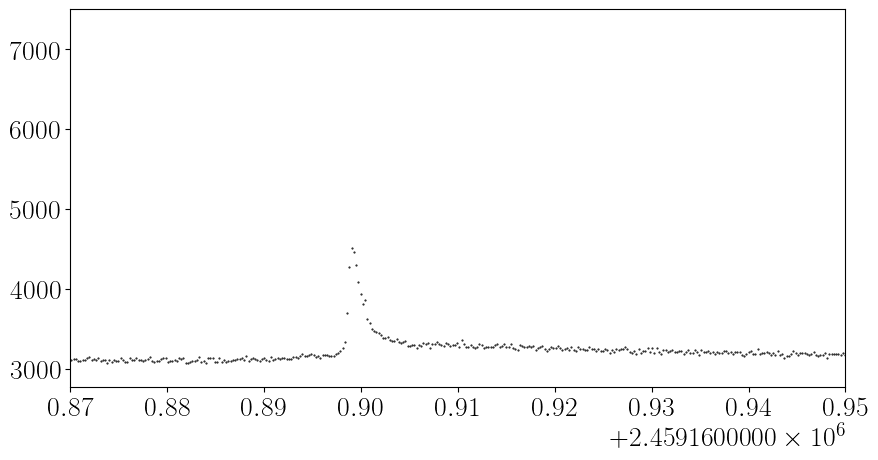

In [43]:
plt.figure(figsize=(10,5))
plt.plot(lc1.time.jd, lc1['sap_flux'], 'k.', markersize=1)
#plt.xlim(60.8+2.4591e6,61+2.4591e6)
plt.xlim(60.87+2.4591e6,60.95+2.4591e6)

(-0.03, 0.5)

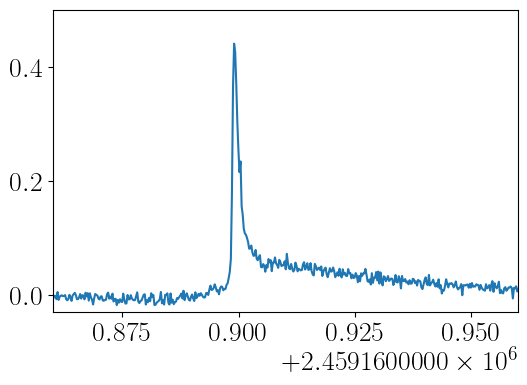

In [44]:
plt.plot(lc1.time.jd,lc1median)
#plt.scatter(60.899+2.4591e6,0.45,color='red',s=10)
plt.xlim(60.86+2.4591e6,60.96+2.4591e6)
plt.ylim(-0.03,0.5)

In [45]:
60.899+2.4591e6

2459160.899

In [46]:
xmin2 = 2459160.86
xmax2 = 2459160.96
#mask2 = ~(np.isnan(lc2.time.jd) | np.isnan(lc2median))
x_mask_f2 = np.where((lc1.time.jd[mask] > xmin2) & (lc1.time.jd[mask] < xmax2))[0]
print(len(x_mask2))
#print(len(lc2.time.jd))

432


In [47]:
f2xfit = lc1.time.jd[mask][x_mask_f2] - 2459160 # approx t_peak
f2yfit = lc1median[mask][x_mask_f2]


#print(f2xfit)

In [48]:
f2 =[0.89907, 0.0016, 0.7] 
#f2=[0.89906826, 0.00178857, 0.44016955]
f2popt, f2pcov = curve_fit(flare_model, f2xfit,f2yfit, p0=f2,maxfev=1000000)
print(f2popt)
print(f2pcov)

[0.89908664 0.00200318 0.41902673]
[[ 5.49981170e-10  4.32963270e-10 -4.52856123e-08]
 [ 4.32963270e-10  5.27108042e-09 -5.51337043e-07]
 [-4.52856123e-08 -5.51337043e-07  1.11968649e-04]]


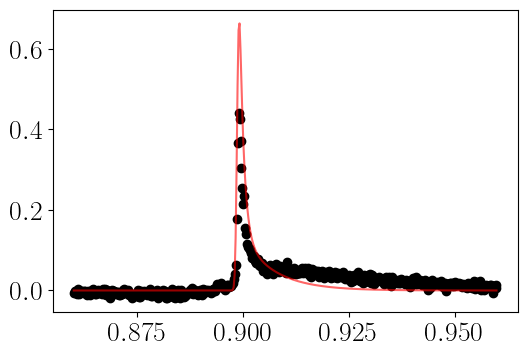

In [49]:
plt.scatter(f2xfit,f2yfit,color='black')
plt.plot(f2xfit, flare_model(f2xfit, *f2),color='red', label='init', alpha=0.6)
#plt.xlim(0.895,0.91)

Fitting V2 of the model

In [50]:
f2v2 =[0.899, 0.0016, 0.6]
#f2=[0.89906826, 0.00178857, 0.44016955]

sortx = np.sort(f2xfit)
sorty = np.sort(f2yfit)
#print(sort)
f2poptv2, f2pcovv2 = curve_fit(flare_model_v2, f2xfit,f2yfit, p0=f2v2,maxfev=1000000)
print(f2poptv2)
print(f2pcovv2)

[0.89911506 0.00208001 0.41428596]
[[ 4.73529569e-10  8.57165639e-10 -8.59219998e-08]
 [ 8.57165639e-10  5.51131634e-09 -5.52415269e-07]
 [-8.59219998e-08 -5.52415269e-07  9.53572693e-05]]


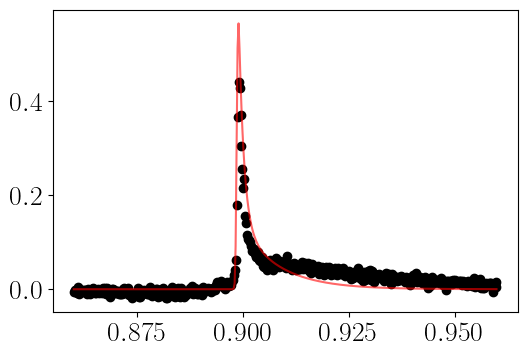

In [51]:
plt.scatter(f2xfit,f2yfit,color='black')
plt.plot(f2xfit, flare_model_v2(f2xfit, *f2v2),color='red', label='init', alpha=0.6)

In [52]:
#print(f2xfit)

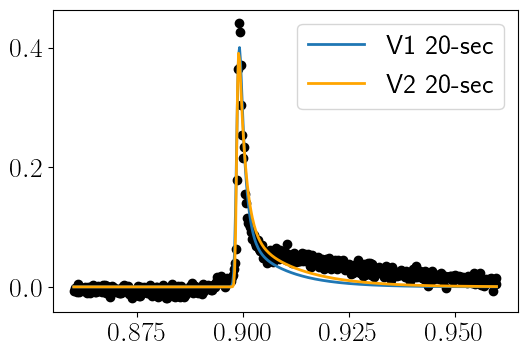

In [53]:
plt.scatter(f2xfit,f2yfit,color='black')
#plt.plot(f2xfit, flare_model(f2xfit, *f2),color='red', label='init', alpha=0.5)
plt.plot(f2xfit, flare_model(f2xfit, *f2popt),color='C0', label='V1 20-sec', lw=2)
plt.plot(f2xfit, flare_model_v2(sortx, *f2poptv2),color='orange', label='V2 20-sec', lw=2)
plt.legend()
#plt.xlim(0.89,0.915)

2min data

In [54]:
f2_mask = np.where((lc2.time.jd[mask2] > xmin2) & (lc2.time.jd[mask2] < xmax2))[0]
f2xfit_2min = lc2.time.jd[mask2][f2_mask] - 2459160 # approx t_peak
f2yfit_2min = lc2median[mask2][f2_mask]

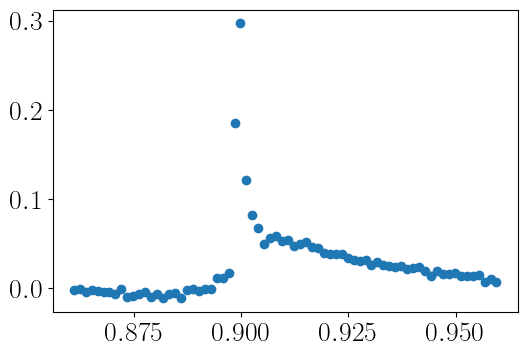

In [55]:
plt.scatter(f2xfit_2min,f2yfit_2min)

In [56]:
f2min =[0.8990, 0.003, 0.55] 
#f2min=[0.8990, .0003, 3.9 ]
best_vals, cov = curve_fit(flare_model, f2xfit_2min,f2yfit_2min, p0=f2min,maxfev=100000)
print(best_vals)
print(cov)

[0.89916578 0.00359773 0.29349695]
[[ 7.59194933e-09  6.42947267e-09 -2.54244229e-07]
 [ 6.42947267e-09  1.10779837e-07 -4.70667785e-06]
 [-2.54244229e-07 -4.70667785e-06  3.27968424e-04]]


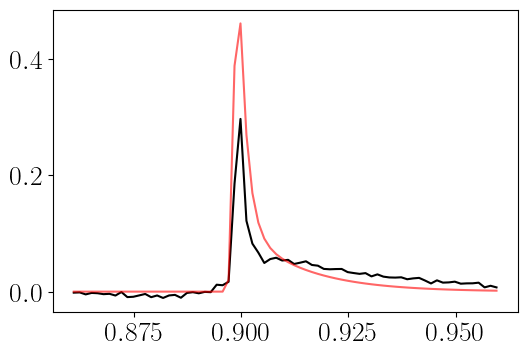

In [57]:
plt.plot(f2xfit_2min,f2yfit_2min,color='black')
plt.plot(f2xfit_2min, flare_model(f2xfit_2min, *f2min),color='red', label='init', alpha=0.6)
#plt.xlim(0.895,0.91)

Fitting V2 of model

In [58]:
f2minv2 =[0.8990, 0.003, 0.65] 
#f2min=[0.8990, .0003, 3.9 ]
best_valsv2, covv2 = curve_fit(flare_model_v2, f2xfit_2min,f2yfit_2min, p0=f2minv2,maxfev=100000)
print(best_valsv2)
print(covv2)

[0.89914872 0.00335614 0.31250517]
[[ 6.60320205e-09  1.43832318e-08 -7.20113114e-07]
 [ 1.43832318e-08  1.32989908e-07 -6.98318981e-06]
 [-7.20113114e-07 -6.98318981e-06  4.81935139e-04]]


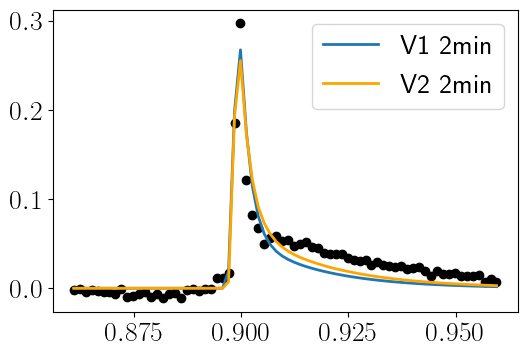

In [59]:
plt.scatter(f2xfit_2min,f2yfit_2min,color='black')
#plt.plot(f2xfit_2min, flare_model(f2xfit_2min, *f2min),color='red', label='init', alpha=0.3)
plt.plot(f2xfit_2min, flare_model(f2xfit_2min, *best_vals),color='C0', label='V1 2min', lw=2)
plt.plot(f2xfit_2min, flare_model_v2(f2xfit_2min, *best_valsv2),color='orange', label='V2 2min', lw=2)
plt.legend()

In [60]:
#try new initialization numbers to see if the fit improves for both the 2min and 2 second cadence data

Comparing 2min v 20sec data

In [61]:
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 25
#rcParams["figure.figsize"] = [8, 4]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ['Verdana']#["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

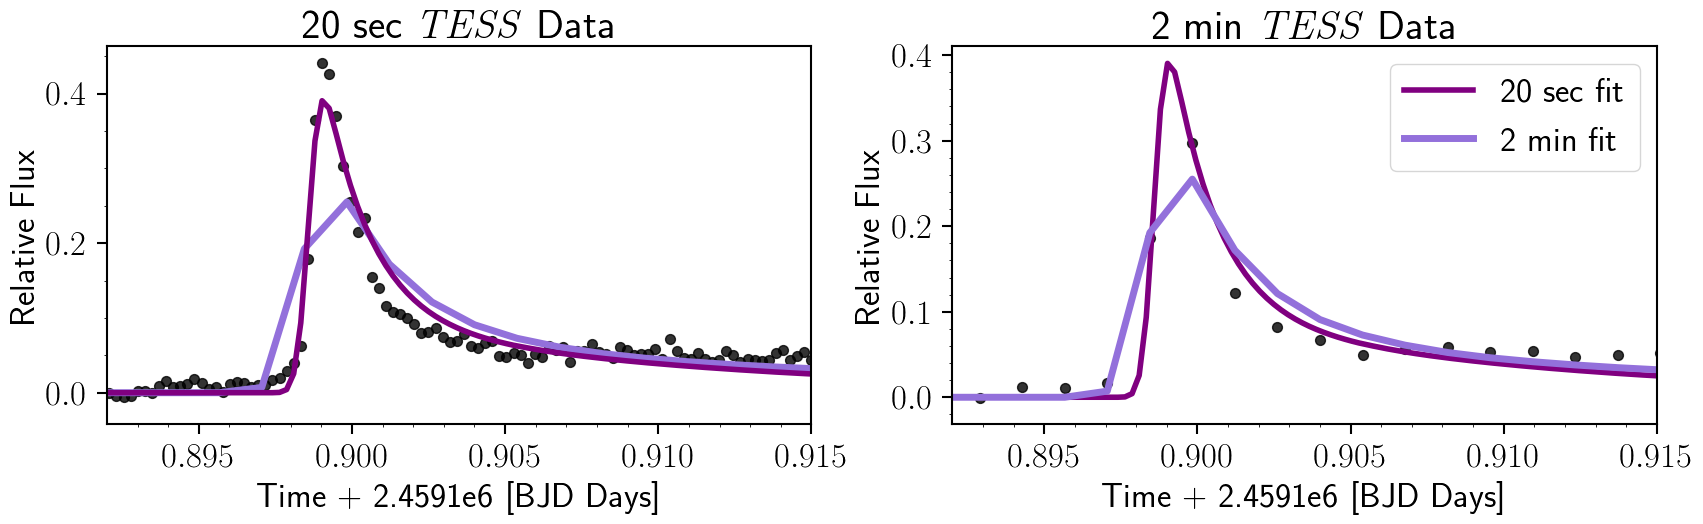

In [69]:
fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k')
plt.rcParams['axes.linewidth']=1.5
axs[0].tick_params(direction='out',width=1.5,length=7,pad=7)
axs[1].tick_params(direction='out',width=1.5,length=7,pad=7)
axs[0].minorticks_on()
axs[1].minorticks_on()

axs[0].scatter(f2xfit,f2yfit,color='black',alpha=0.8,label = '20 sec $\it{TESS}$ data',s=50)
#plt.plot(xfit, aflare1(xfit, *init_vals2),color='red', label='init', alpha=0.3)
#axs[0].plot(xfit, aflare1(xfit, *j_popt),color='C0', label='Jim Model', lw=2)
#axs[0].plot(f2xfit, flare_model(f2xfit, *f2popt),color='C0', label='Analytic model', lw=3)

axs[0].plot(f2xfit_2min, flare_model_v2(f2xfit_2min, *best_valsv2),color='mediumpurple', label='2 min fit', lw=5)
axs[0].plot(f2xfit, flare_model_v2(f2xfit, *f2poptv2),color='purple', label='20 sec fit', lw=4)
#axs[0].legend()
axs[0].set_xlim(0.892,0.915)
axs[0].set_xlabel('Time + 2.4591e6 [BJD Days]',fontsize=25)
axs[0].set_ylabel('Relative Flux',fontsize=25)
axs[0].set_title('20 sec $\it{TESS}$ Data')
#axs[0].legend()


axs[1].scatter(f2xfit_2min,f2yfit_2min,color='black',alpha=0.8,s=50)
#plt.plot(xfit_2min, flare_model(xfit_2min, *init_vals),color='red', label='init', alpha=0.3)
#axs[1].plot(f2xfit_2min, flare_model(f2xfit_2min, *best_vals),color='olive', label='Analytic Model', lw=3)
axs[1].plot(f2xfit, flare_model_v2(f2xfit, *f2poptv2),color='purple', label='20 sec fit', lw=4)
axs[1].plot(f2xfit_2min, flare_model_v2(f2xfit_2min, *best_valsv2),color='mediumpurple', label='2 min fit', lw=5)
#axs[1].plot(f2xfit_2min, flare_model(f2xfit_2min, *popt2),color='purple', label='New model', lw=2)
#axs[1].legend()
axs[1].set_xlim(0.892,0.915)
axs[1].set_xlabel('Time + 2.4591e6  [BJD Days]',fontsize=25)
axs[1].set_ylabel('Relative Flux',fontsize=25)
axs[1].set_title('2 min $\it{TESS}$ Data')
axs[1].legend()
#plt.savefig('/Users/lupitatovar/local_flares/paper_figs/tess_exs_flare2_fit_purple.png',bbox_inches='tight')

Text(0.5, 1.0, '2 min {TESS} Data')

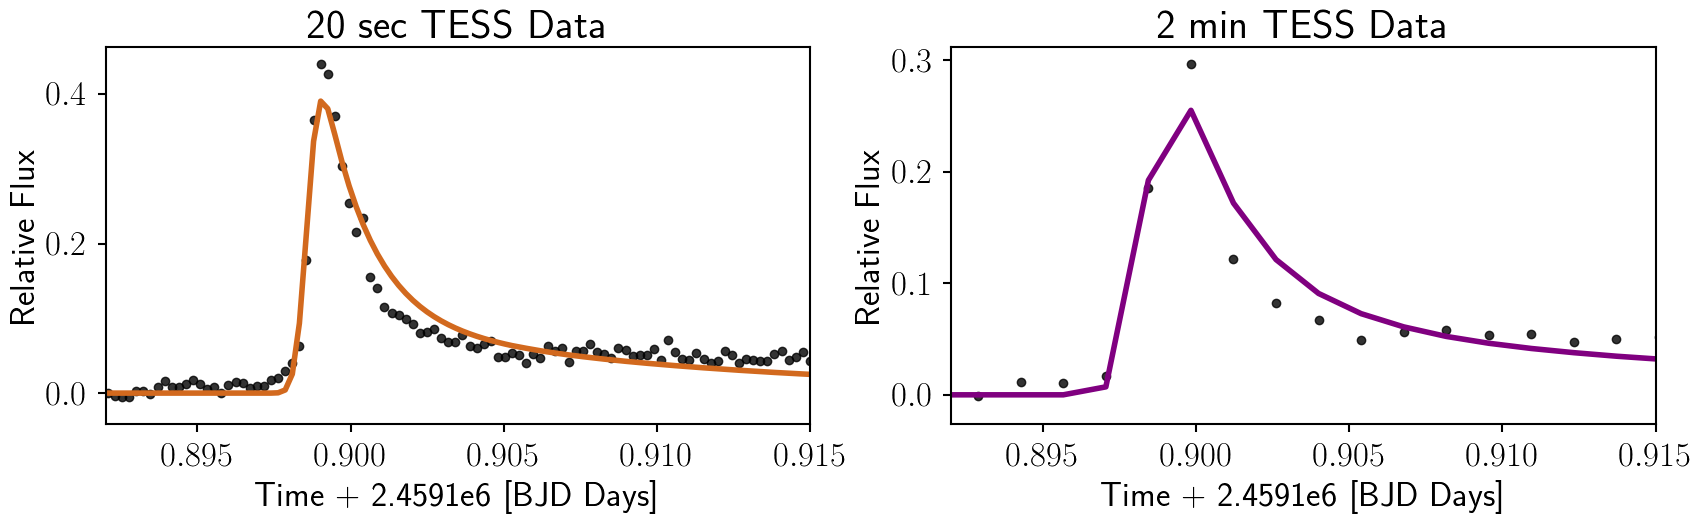

In [70]:
fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k')
plt.rcParams['axes.linewidth']=1.5
axs[0].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[1].tick_params(direction='out',width=1.5,length=6,pad=7)


axs[0].scatter(f2xfit,f2yfit,color='black',alpha=0.8)
#plt.plot(xfit, aflare1(xfit, *init_vals2),color='red', label='init', alpha=0.3)
#axs[0].plot(xfit, aflare1(xfit, *j_popt),color='C0', label='Jim Model', lw=2)
#axs[0].plot(f2xfit, flare_model(f2xfit, *f2popt),color='C0', label='Analytic model', lw=3)
axs[0].plot(f2xfit, flare_model_v2(f2xfit, *f2poptv2),color='chocolate', label='V2 20-sec', lw=4)
#axs[0].plot(f2xfit_2min, flare_model_v2(f2xfit_2min, *best_valsv2),color='purple', label='V2 2min', lw=4)
#axs[0].legend()
axs[0].set_xlim(0.892,0.915)
axs[0].set_xlabel('Time + 2.4591e6 [BJD Days]',fontsize=25)
axs[0].set_ylabel('Relative Flux',fontsize=25)
axs[0].set_title('20 sec TESS Data')


axs[1].scatter(f2xfit_2min,f2yfit_2min,color='black',alpha=0.8)
#plt.plot(xfit_2min, flare_model(xfit_2min, *init_vals),color='red', label='init', alpha=0.3)
#axs[1].plot(f2xfit_2min, flare_model(f2xfit_2min, *best_vals),color='olive', label='Analytic Model', lw=3)
axs[1].plot(f2xfit_2min, flare_model_v2(f2xfit_2min, *best_valsv2),color='purple', label='V2 2min', lw=4)
#axs[1].plot(f2xfit, flare_model_v2(f2xfit, *f2poptv2),color='chocolate', label='V2 20-sec', lw=4)
#axs[1].plot(f2xfit_2min, flare_model(f2xfit_2min, *popt2),color='purple', label='New model', lw=2)
#axs[1].legend()
axs[1].set_xlim(0.892,0.915)
axs[1].set_xlabel('Time + 2.4591e6  [BJD Days]',fontsize=25)
axs[1].set_ylabel('Relative Flux',fontsize=25)
axs[1].set_title('2 min {TESS} Data')
#plt.savefig('/Users/lupitatovar/local_flares/figures/tess_exs_flare2_fit.png',bbox_inches='tight')

In [71]:
###Fitting with the tess_model values
def flare_model_tess(t,tpeak, fwhm, ampl, upsample=False, uptime=10):

    t_new = (t-tpeak)/fwhm +2


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    #A,B,C,D1,D2,f1 = 2.28498875e+01,  3.66808382e+00, -3.07542717e-02,  2.26971471e-02, 8.70691332e-01,  3.52620946e-02
    A,B,C,D1,D2,f1= 3.534030981419442,1.7407580284521358,0.21064643920120174,0.24216803276366616,1.4047763266818487,0.22994796457092795
    #previous [3.46452433, 1.74147744, 0.21642749, 0.22529023, 1.39565111, 0.21624606] from Kepler model
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    
    if upsample:
        dt = np.nanmedian(np.diff(np.abs(t_new)))
        timeup = np.linspace(min(t_new)-dt, max(t_new)+dt, t_new.size * uptime)

        flareup = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-timeup)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (timeup/C))))
                                                 + (f2 * np.exp((D2*(B-timeup)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (timeup/C)))))

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t_new-dt/2.,[max(t_new)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',bins=downbins)
    else:

        flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                                 + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))

    erf_bound = 0.5*(special.erf((t_new-0.2)*100) + 1)

    return flare * ampl * erf_bound


In [72]:
f2min_tess =[0.8990, 0.003, 0.65] 
#f2min=[0.8990, .0003, 3.9 ]
best_tess, covtess = curve_fit(flare_model_tess, f2xfit_2min,f2yfit_2min, p0=f2min_tess,maxfev=100000)
print(best_tess)
print(covtess)

[0.89933127 0.00409444 0.27264318]
[[ 9.42692042e-09  2.04160950e-08 -6.44182790e-07]
 [ 2.04160950e-08  2.05824232e-07 -7.25372008e-06]
 [-6.44182790e-07 -7.25372008e-06  3.70642266e-04]]


In [73]:
f2_20s_tess =[0.899, 0.0016, 0.6]
#f2=[0.89906826, 0.00178857, 0.44016955]

#print(sort)
f2popt_tess, f2pcov_tess = curve_fit(flare_model_tess, f2xfit,f2yfit, p0=f2_20s_tess,maxfev=1000000)
print(f2popt_tess)
print(f2pcov_tess)

[0.89914273 0.00211004 0.40562141]
[[ 6.35273509e-10  1.10631810e-09 -1.06346273e-07]
 [ 1.10631810e-09  6.78587653e-09 -6.52306274e-07]
 [-1.06346273e-07 -6.52306274e-07  1.12681122e-04]]


Text(0.5, 1.0, '2 min {TESS} Data')

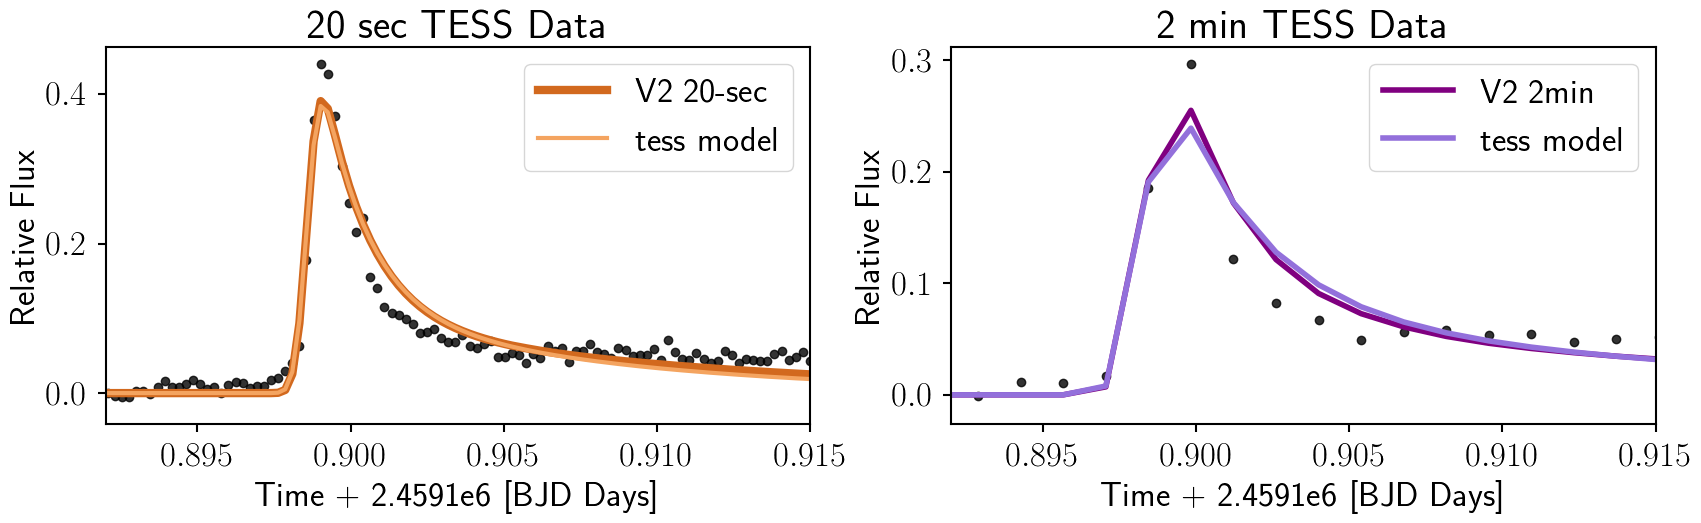

In [74]:
fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k')
plt.rcParams['axes.linewidth']=1.5
axs[0].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[1].tick_params(direction='out',width=1.5,length=6,pad=7)


axs[0].scatter(f2xfit,f2yfit,color='black',alpha=0.8)
#plt.plot(xfit, aflare1(xfit, *init_vals2),color='red', label='init', alpha=0.3)
#axs[0].plot(xfit, aflare1(xfit, *j_popt),color='C0', label='Jim Model', lw=2)
#axs[0].plot(f2xfit, flare_model(f2xfit, *f2popt),color='C0', label='Analytic model', lw=3)
axs[0].plot(f2xfit, flare_model_v2(f2xfit, *f2poptv2),color='chocolate', label='V2 20-sec', lw=6)
axs[0].plot(f2xfit, flare_model_tess(f2xfit, *f2popt_tess),color='sandybrown', label='tess model', lw=3)
#axs[0].plot(f2xfit_2min, flare_model_v2(f2xfit_2min, *best_valsv2),color='purple', label='V2 2min', lw=4)
#axs[0].plot(f2xfit_2min, flare_model_tess(f2xfit_2min, *best_tess),color='mediumpurple', label='2 min fit', lw=4)

#axs[0].plot(f2xfit_2min, flare_model_v2(f2xfit_2min, *best_valsv2),color='purple', label='V2 2min', lw=4)
axs[0].legend()
axs[0].set_xlim(0.892,0.915)
axs[0].set_xlabel('Time + 2.4591e6 [BJD Days]',fontsize=25)
axs[0].set_ylabel('Relative Flux',fontsize=25)
axs[0].set_title('20 sec TESS Data')


axs[1].scatter(f2xfit_2min,f2yfit_2min,color='black',alpha=0.8)
#plt.plot(xfit_2min, flare_model(xfit_2min, *init_vals),color='red', label='init', alpha=0.3)
#axs[1].plot(f2xfit_2min, flare_model(f2xfit_2min, *best_vals),color='olive', label='Analytic Model', lw=3)
axs[1].plot(f2xfit_2min, flare_model_v2(f2xfit_2min, *best_valsv2),color='purple', label='V2 2min', lw=4)
axs[1].plot(f2xfit_2min, flare_model_tess(f2xfit_2min, *best_tess),color='mediumpurple', label='tess model', lw=4)
#axs[1].plot(f2xfit, flare_model_v2(f2xfit, *f2poptv2),color='chocolate', label='V2 20-sec', lw=4)
#axs[1].plot(f2xfit_2min, flare_model(f2xfit_2min, *popt2),color='purple', label='New model', lw=2)
axs[1].legend()
axs[1].set_xlim(0.892,0.915)
axs[1].set_xlabel('Time + 2.4591e6  [BJD Days]',fontsize=25)
axs[1].set_ylabel('Relative Flux',fontsize=25)
axs[1].set_title('2 min {TESS} Data')
#plt.savefig('/Users/lupitatovar/local_flares/figures/tess_exs_flare2_fit.png',bbox_inches='tight')

Tess Model Fits; uses the full flare modeling process/values derived for TESS data

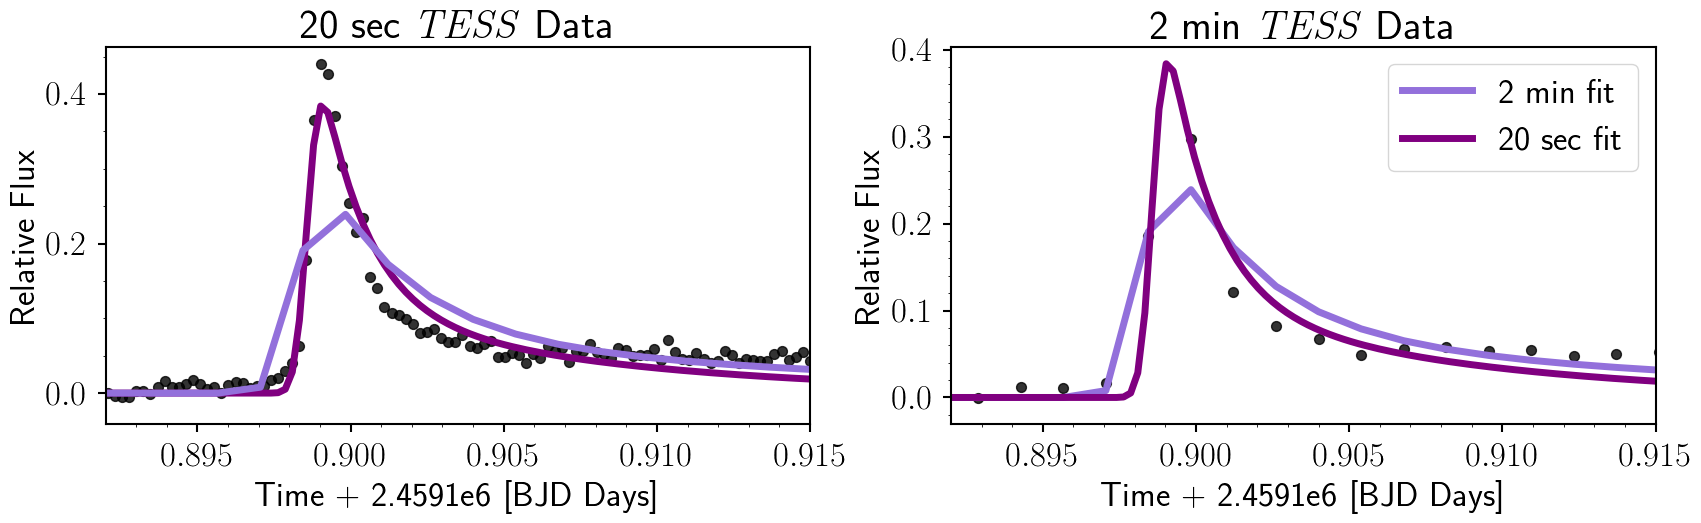

In [75]:
fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k')
plt.rcParams['axes.linewidth']=1.5
axs[0].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[1].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[0].minorticks_on()
axs[1].minorticks_on()

axs[0].scatter(f2xfit,f2yfit,color='black',alpha=0.8,label = '20 sec $\it{TESS}$ data',s=50)
#plt.plot(xfit, aflare1(xfit, *init_vals2),color='red', label='init', alpha=0.3)
#axs[0].plot(xfit, aflare1(xfit, *j_popt),color='C0', label='Jim Model', lw=2)
#axs[0].plot(f2xfit, flare_model(f2xfit, *f2popt),color='C0', label='Analytic model', lw=3)

#axs[0].plot(f2xfit_2min, flare_model_v2(f2xfit_2min, *best_valsv2),color='mediumpurple', label='2 min fit', lw=5)
#axs[0].plot(f2xfit, flare_model_v2(f2xfit, *f2poptv2),color='purple', label='20 sec fit', lw=4)
axs[0].plot(f2xfit, flare_model_tess(f2xfit, *f2popt_tess),color='purple', label='tess model 20s', lw=5)
axs[0].plot(f2xfit_2min, flare_model_tess(f2xfit_2min, *best_tess),color='mediumpurple', label='tess model 2min', lw=5)
#axs[0].legend()
axs[0].set_xlim(0.892,0.915)
axs[0].set_xlabel('Time + 2.4591e6 [BJD Days]',fontsize=25)
axs[0].set_ylabel('Relative Flux',fontsize=25)
axs[0].set_title('20 sec $\it{TESS}$ Data')
#axs[0].legend()


axs[1].scatter(f2xfit_2min,f2yfit_2min,color='black',alpha=0.8,s=50)
#plt.plot(xfit_2min, flare_model(xfit_2min, *init_vals),color='red', label='init', alpha=0.3)
#axs[1].plot(f2xfit_2min, flare_model(f2xfit_2min, *best_vals),color='olive', label='Analytic Model', lw=3)
#axs[1].plot(f2xfit, flare_model_v2(f2xfit, *f2poptv2),color='purple', label='20 sec fit', lw=4)
#axs[1].plot(f2xfit_2min, flare_model_v2(f2xfit_2min, *best_valsv2),color='mediumpurple', label='2 min fit', lw=5)

axs[1].plot(f2xfit_2min, flare_model_tess(f2xfit_2min, *best_tess),color='mediumpurple', label='2 min fit', lw=5)
axs[1].plot(f2xfit, flare_model_tess(f2xfit, *f2popt_tess),color='purple', label='20 sec fit', lw=5)
#axs[1].plot(f2xfit_2min, flare_model(f2xfit_2min, *popt2),color='purple', label='New model', lw=2)
#axs[1].legend()
axs[1].set_xlim(0.892,0.915)
axs[1].set_xlabel('Time + 2.4591e6  [BJD Days]',fontsize=25)
axs[1].set_ylabel('Relative Flux',fontsize=25)
axs[1].set_title('2 min $\it{TESS}$ Data')
axs[1].legend()
#plt.savefig('/Users/lupitatovar/local_flares/figures/tess_model_flare2_fit_purple.png',bbox_inches='tight')